<a href="https://colab.research.google.com/github/mshitie/MS_KD/blob/main/knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rarfile

from google.colab import drive
import rarfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the .rar file in Google Drive
rar_path = '/content/drive/MyDrive/computer_vision/main_data_croped.rar'

# Destination folder to extract the contents
destination_folder = '/content'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Extract the .rar file
with rarfile.RarFile(rar_path, 'r') as rar_ref:
    rar_ref.extractall(destination_folder)

print("Extraction completed.")

Mounted at /content/drive
Extraction completed.


In [2]:
import os
import csv
import shutil

def partition_images(directory, csv_file, output_folder):
    image_files = []
    folder_counts = {}  # Dictionary to store the count of images moved to each folder

    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip the header row if it exists

        # Iterate over the rows in the CSV file
        for row in reader:
            image_file = row[0]  # Assuming the image file names are in the first column
            label = row[1]  # Assuming the labels are in the second column
            image_files.append((image_file, label))

    # Create directories for each label
    labels = set(label for _, label in image_files)
    for label in labels:
        label_dir = os.path.join(output_folder, label)
        os.makedirs(label_dir, exist_ok=True)
        folder_counts[label] = 0  # Initialize the count to 0

    # Move the image files to separate label directories
    for image_file, label in image_files:
        source_path = os.path.join(directory, image_file + ".jpg")  # Assuming the file extension is '.jpg'
        destination_path = os.path.join(output_folder, label, image_file + ".jpg")

        if os.path.exists(source_path):
            print(f"Moving {source_path} to {destination_path}")
            shutil.move(source_path, destination_path)
            folder_counts[label] += 1  # Increment the count for the corresponding folder

        else:
            print(f"File not found: {source_path}")

    # Print the counts for each folder
    print("\nNumber of images moved in each folder:")
    for label, count in folder_counts.items():
        print(f"{label}: {count}")

# Directory path where the images and CSV file are located
directory_path = '/content/main_data_croped/'
csv_file_path = '/content/drive/MyDrive/computer_vision/tfti2.csv'
output_folder = "/content/main_data_croped2/"

# Create the output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Call the function to partition the images based on the labels
partition_images(directory_path, csv_file_path, output_folder)

Moving /content/main_data_croped/image1.jpg to /content/main_data_croped2/1/image1.jpg
Moving /content/main_data_croped/image2.jpg to /content/main_data_croped2/2/image2.jpg
Moving /content/main_data_croped/image3.jpg to /content/main_data_croped2/1/image3.jpg
Moving /content/main_data_croped/image4.jpg to /content/main_data_croped2/1/image4.jpg
Moving /content/main_data_croped/image5.jpg to /content/main_data_croped2/2/image5.jpg
Moving /content/main_data_croped/image6.jpg to /content/main_data_croped2/3/image6.jpg
Moving /content/main_data_croped/image7.jpg to /content/main_data_croped2/1/image7.jpg
Moving /content/main_data_croped/image8.jpg to /content/main_data_croped2/4/image8.jpg
Moving /content/main_data_croped/image9.jpg to /content/main_data_croped2/1/image9.jpg
Moving /content/main_data_croped/image10.jpg to /content/main_data_croped2/4/image10.jpg
Moving /content/main_data_croped/image11.jpg to /content/main_data_croped2/2/image11.jpg
Moving /content/main_data_croped/image1

In [3]:
# Paper KD1
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

import time
import timeit

<ipython-input-3-2c278fa19bae>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

In [6]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_dir = '/content/main_data_croped2'

# Function to load images from a directory
def load_images_from_dir(directory):
    images = []
    labels = []
    label_mapping = {'TF': 0, 'TI': 1, 'normal': 2}  # Mapping of label names to indices

    for label_name in label_mapping.keys():
        label_dir = os.path.join(directory, label_name)

        for filename in os.listdir(label_dir):
            img = Image.open(os.path.join(label_dir, filename)).convert('RGB')
            img = img.resize((224, 224))  # Resize if necessary
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label_mapping[label_name])

    return np.array(images), np.array(labels)

# Load images and labels from the training directory
X_train, Y_train = load_images_from_dir(train_dir)

print('Done Loaded :)')

# Shape of the training dataset
print(f'X train shape:', X_train.shape)
print(f'Y train shape:', Y_train.shape)

# Split the training data into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=10)

# Convert the labels to one-hot encoded vectors
num_classes = 3
Y_train = to_categorical(y_train, num_classes=num_classes)
Y_val = to_categorical(y_val, num_classes=num_classes)
Y_test = to_categorical(y_test, num_classes=num_classes)

print(f'x train shape:', x_train.shape)
print(f'x val shape:', x_val.shape)
print(f'x test shape:', x_test.shape)
print(f'y train shape:', y_train.shape)
print(f'y val shape:', y_val.shape)
print(f'y test shape:', y_test.shape)
print(f'Y train shape:', Y_train.shape)
print(f'Y val shape:', Y_val.shape)
print(f'Y test shape:', Y_test.shape)

Done Loaded :)
X train shape: (1494, 224, 224, 3)
Y train shape: (1494,)
x train shape: (1195, 224, 224, 3)
x val shape: (149, 224, 224, 3)
x test shape: (150, 224, 224, 3)
y train shape: (1195,)
y val shape: (149,)
y test shape: (150,)
Y train shape: (1195, 3)
Y val shape: (149, 3)
Y test shape: (150, 3)


In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_dir = '/content/main_data_croped2'
#test_dir = '/content/drive/MyDrive/computer_vision/main_dataset33/test'

# Load train images
tf_train = []
for filename in os.listdir(os.path.join(train_dir, 'TF')):
    img = Image.open(os.path.join(train_dir, 'TF', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    tf_train.append(img_array)
tf_train = np.array(tf_train)

it_train = []
for filename in os.listdir(os.path.join(train_dir, 'TI')):
    img = Image.open(os.path.join(train_dir, 'TI', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    it_train.append(img_array)
it_train = np.array(it_train)

normal_train = []
for filename in os.listdir(os.path.join(train_dir, 'normal')):
    img = Image.open(os.path.join(train_dir, 'normal', filename)).convert('RGB')
    img = img.resize((224, 224))  # Resize if necessary
    img_array = np.array(img)
    normal_train.append(img_array)
normal_train = np.array(normal_train)



print('Done Loaded :)')

# Shape of our dataset
print(f'TF Train:', tf_train.shape)
print(f'TI Train:', it_train.shape)
print(f'Normal Train:', normal_train.shape)


tf_train_label = np.zeros(len(tf_train), dtype=float)
it_train_label = np.ones(len(it_train), dtype=float)
normal_train_label = np.full(len(normal_train), 2, dtype=float)


X_train = np.concatenate((tf_train, it_train, normal_train), axis=0)
Y_train = np.concatenate((tf_train_label, it_train_label, normal_train_label), axis=0)


s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]


Y_train = to_categorical(Y_train, num_classes=3)


print(f'X train shape:', X_train.shape)

print(f'Y train shape:', Y_train.shape)

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)

print(f'x train shape:', x_train.shape)
print(f'x test shape:', x_test.shape)
print(f'x val shape:', x_val.shape)
print(f'y train shape:', y_train.shape)
print(f'y test shape:', y_test.shape)
print(f'y val shape:', y_val.shape)

Done Loaded :)
TF Train: (365, 224, 224, 3)
TI Train: (110, 224, 224, 3)
Normal Train: (1019, 224, 224, 3)
X train shape: (1494, 224, 224, 3)
Y train shape: (1494, 3)
x train shape: (1344, 224, 224, 3)
x test shape: (150, 224, 224, 3)
x val shape: (150, 224, 224, 3)
y train shape: (1344, 3)
y test shape: (150, 3)
y val shape: (150, 3)


In [6]:
from tensorflow.keras.applications import MobileNet
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(3 , activation='softmax'))

  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )

  return model

resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224 , 224 , 3)
)
# call the model
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                         

In [7]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
filepath="ResNet50weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [8]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
# Configuration
import time
epochs = 10
batch_size = 32

# Calculate the starting time
start_time = time.time()

teacher_his = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_val, y_val),
            callbacks=[learn_control, checkpoint])


end_time = time.time()
print("--- Time taken to train : %s seconds ---" % ((end_time - start_time)))

Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.1616 - accuracy: 0.5759

42/42 [==============================] - 67s 358ms/step - loss: 1.1616 - accuracy: 0.5759 - val_loss: 0.9972 - val_accuracy: 0.6200 - lr: 1.0000e-04
Epoch 2/10
42/42 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8400

42/42 [==============================] - 13s 302ms/step - loss: 0.4629 - accuracy: 0.8400 - val_loss: 0.7795 - val_accuracy: 0.7333 - lr: 1.0000e-04
Epoch 3/10
42/42 [==============================] - ETA: 0s - loss: 0.1475 - accuracy: 0.9524

42/42 [==============================] - 13s 303ms/step - loss: 0.1475 - accuracy: 0.9524 - val_loss: 1.4803 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 4/10
42/42 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9732

42/42 [==============================] - 13s 310ms/step - loss: 0.1285 - accuracy: 0.9732 - val_loss: 0.7974 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 5/10
42/42 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9717

42/42 [==============================] - 13s 308ms/step - loss: 0.0879 - accuracy: 0.9717 - val_loss: 0.9628 - val_accuracy: 0.8533 - lr: 1.0000e-04
Epoch 6/10
42/42 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9754

42/42 [==============================] - 13s 318ms/step - loss: 0.0886 - accuracy: 0.9754 - val_loss: 1.0510 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/10
42/42 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9643

42/42 [==============================] - 13s 319ms/step - loss: 0.0968 - accuracy: 0.9643 - val_loss: 0.7433 - val_accuracy: 0.8733 - lr: 1.0000e-04
Epoch 8/10
42/42 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9814

42/42 [==============================] - 14s 324ms/step - loss: 0.0567 - accuracy: 0.9814 - val_loss: 0.6915 - val_accuracy: 0.8400 - lr: 1.0000e-04
Epoch 9/10
42/42 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9799

42/42 [==============================] - 14s 323ms/step - loss: 0.0667 - accuracy: 0.9799 - val_loss: 1.4088 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 10/10
42/42 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9799

42/42 [==============================] - 14s 325ms/step - loss: 0.0610 - accuracy: 0.9799 - val_loss: 0.6697 - val_accuracy: 0.8200 - lr: 1.0000e-04
--- Time taken to train : 218.2087185382843 seconds ---


In [9]:
model.save_weights("ResNet50_model.h5") #using h5 extension
print("model saved!!!")

model saved!!!


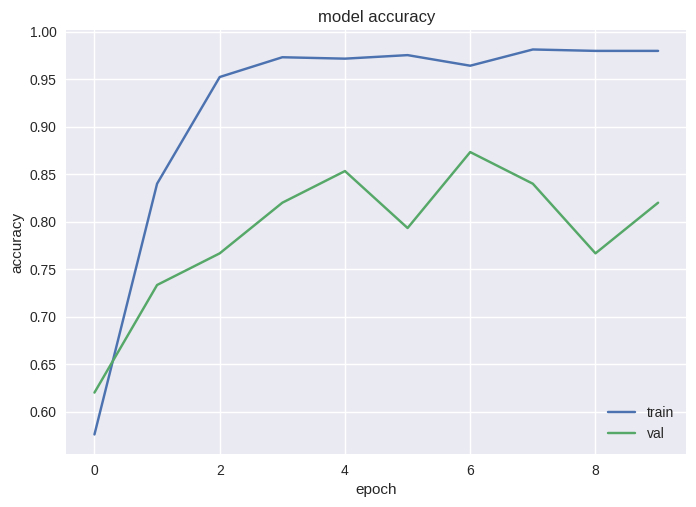

In [10]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

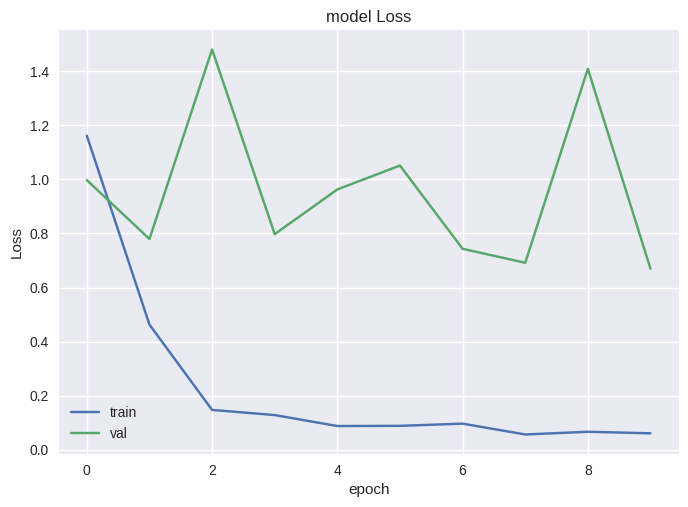

In [11]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [12]:
Y_val_pred = model.predict(x_val)
print(f'The Teacher model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

5/5 [==============================] - 2s 95ms/step
The Teacher model Accuracy on the Validation Set: 0.82


In [14]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,y_test)

My Y_test values are:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 

In [15]:

#Now let's check my predcited values from X_test dataset
# And calculate the y_pred with time
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(x_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 1s 101ms/step
My predicted Y_test values are:
 [[9.43291903e-01 4.22514230e-03 5.24829887e-02]
 [3.23740314e-05 1.85241632e-04 9.99782383e-01]
 [1.35785644e-03 1.39327091e-03 9.97248828e-01]
 [9.92435277e-01 7.51598598e-03 4.87096040e-05]
 [7.48016246e-05 2.08964266e-04 9.99716222e-01]
 [9.98263538e-01 1.73642836e-03 1.45355492e-10]
 [2.40060710e-03 6.15256140e-03 9.91446853e-01]
 [9.92736936e-01 2.38035852e-03 4.88271844e-03]
 [9.30864085e-03 9.10355709e-04 9.89781022e-01]
 [4.17811610e-03 2.66446709e-03 9.93157446e-01]
 [1.84052298e-03 6.09850418e-03 9.92061019e-01]
 [9.99761164e-01 2.38893132e-04 1.35669431e-08]
 [8.73893558e-04 1.25280879e-02 9.86598015e-01]
 [1.14702247e-03 2.46931356e-03 9.96383667e-01]
 [1.00000000e+00 4.74970840e-10 0.00000000e+00]
 [7.44411886e-01 1.05155803e-01 1.50432304e-01]
 [9.83429313e-01 7.46876700e-03 9.10193287e-03]
 [2.57058647e-02 1.07023735e-02 9.63591754e-01]
 [9.99950528e-01 4.82214928e-05 1.23193331e-06]
 [

In [17]:
start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Teacher model with ResNet50 on the Test set is: 0.82

Time:  0.005084579000026679 sec


In [19]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))


Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78        42
           1       0.78      0.47      0.58        15
           2       0.85      0.89      0.87        93

    accuracy                           0.82       150
   macro avg       0.80      0.71      0.74       150
weighted avg       0.82      0.82      0.81       150



Auc Curve on Validation:



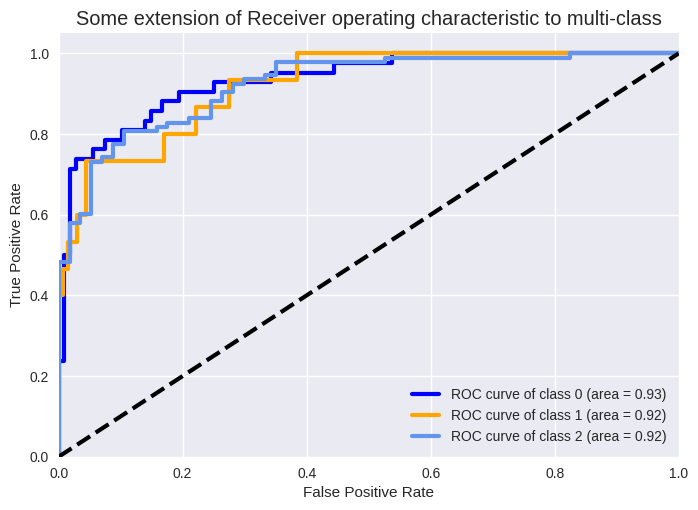

In [20]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], Y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), Y_val_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



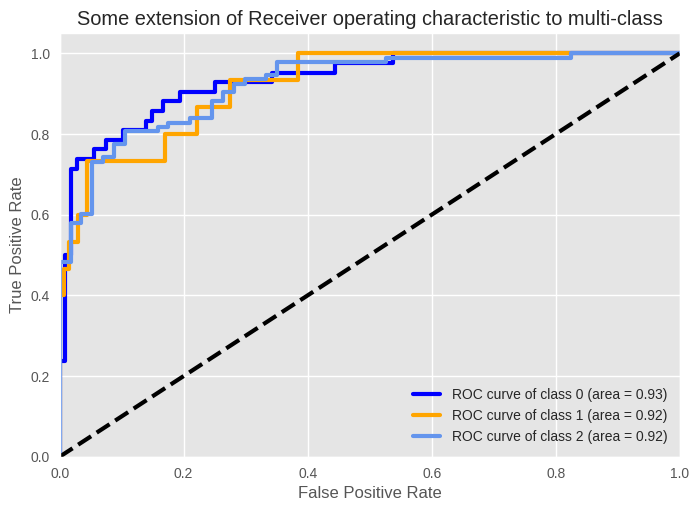

In [23]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [24]:

# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 3

customstudent = Sequential()
customstudent.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(64, (3, 3), activation='relu'))
customstudent.add(MaxPooling2D(pool_size=(2, 2)))
customstudent.add(Conv2D(32, (3, 3), activation='relu'))
customstudent.add(Dropout(0.25)) # For reguralization

customstudent.add(layers.Flatten())

customstudent.add(layers.Dense(nb_classes))
customstudent.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


customstudent.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(customstudent.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        18464     
                                                                 
 dropout_1 (Dropout)         (None, 52, 52, 32)       

In [26]:

# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets

# Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense').output)

In [27]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

In [28]:
# Prepare the soft targets and the target data for student to be trained upon
# From our temperature experiment we get temp = 10 is gave is best results
temp = 10
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val)

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 10
test_logits_T = teacher_test_logits / temp

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)


5/5 [==============================] - 1s 100ms/step
(1344, 3)
(150, 3)
(1344, 6)
(150, 6)


In [29]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
temp = 10
customstudent.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = customstudent.layers[-1].output
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
customstudent = Model(customstudent.input, output)

customstudent.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_input (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 128)        3584      ['conv2d_input[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)        0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         73792     ['max_pooling2d[0][0]'] 

In [30]:

# Declare knowledge distillation loss function
# This will be a teacher trained student model.
# This uses a knowledge distillation loss function
# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]

    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]

    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)

    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

customstudent.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc]
  )

In [31]:

# Train the student model
epochs = 20
batch_size = 18
customstudent_student_his = customstudent.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
75/75 [==============================] - 15s 161ms/step - loss: 0.1102 - acc: 0.4479 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 2/20
75/75 [==============================] - 11s 142ms/step - loss: 0.0883 - acc: 0.6741 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 3/20
75/75 [==============================] - 11s 142ms/step - loss: 0.0875 - acc: 0.6830 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 4/20
75/75 [==============================] - 11s 141ms/step - loss: 0.0872 - acc: 0.6875 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 5/20
75/75 [==============================] - 11s 141ms/step - loss: 0.0869 - acc: 0.6897 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 6/20
75/75 [==============================] - 11s 141ms/step - loss: 0.0871 - acc: 0.6882 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 7/20
75/75 [==============================] - 11s 141ms/step - loss: 0.0872 - acc: 0.6868 - val_loss: 0.0997 - val_acc: 0.6200
Epoch 8/20
75/75 [==============================] - 11s 142ms/step - 

<ipython-input-32-4dfd3e4fd4f9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


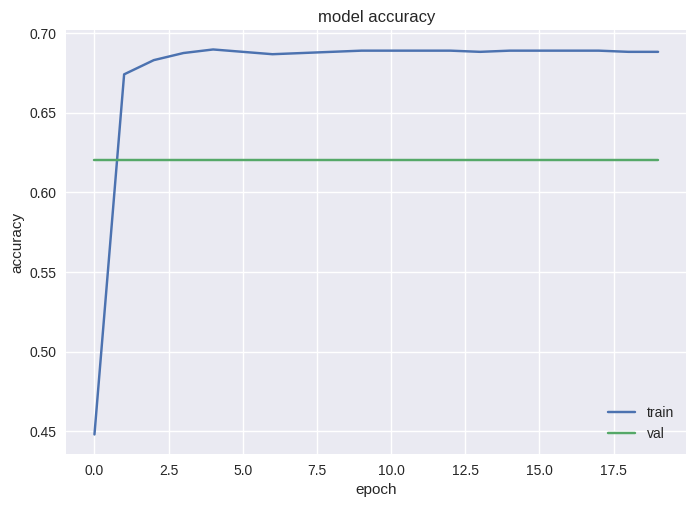

In [32]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.style.use('seaborn')
plt.plot(customstudent_student_his.history['acc'])
plt.plot(customstudent_student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

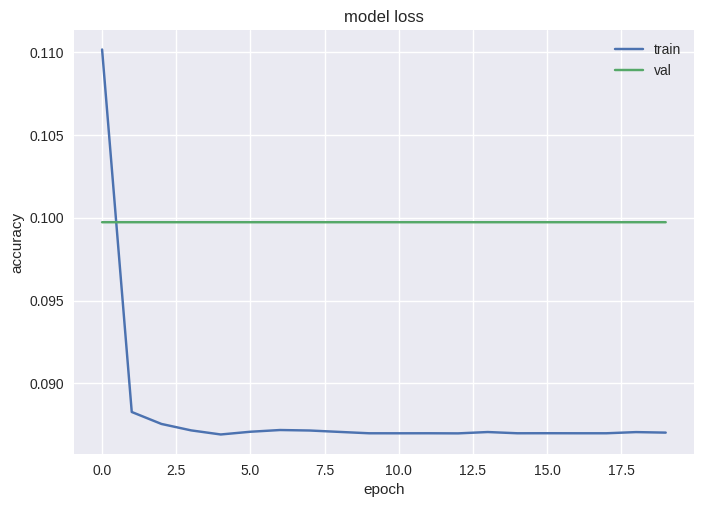

In [33]:

#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(customstudent_student_his.history['loss'])
plt.plot(customstudent_student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [34]:
Y_val_pred_student = customstudent.predict(x_val)
print(f'The CustomStudent model Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred_student, axis=1)))


5/5 [==============================] - 2s 180ms/step
The CustomStudent model Accuracy on the Validation Set: 0.62


In [36]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,y_test)

My Y_test values are:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 

In [37]:

#Now let's check my predcited values from X_test dataset
import timeit

start = timeit.default_timer()
#Your statements here
y_pred_student = customstudent.predict(x_test)
print(f'My predicted Y_test values are:\n' ,y_pred_student)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

5/5 [==============================] - 0s 33ms/step
My predicted Y_test values are:
 [[0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.21194157 0.57611686 0.32204345 0.32204345 0.35591307]
 [0.21194157 0.211

In [38]:

start = timeit.default_timer()
#Your statements here

#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Custom Student model on the Test set is:',accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_student, axis=1)))

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My accuracy on Custom Student model on the Test set is: 0.62

Time:  0.00961374500002421 sec


In [40]:
# Classification_report
print(f'Classification Report of Resnet50:\n',classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred_student, axis=1)))


Classification Report of Resnet50:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        15
           2       0.62      1.00      0.77        93

    accuracy                           0.62       150
   macro avg       0.21      0.33      0.26       150
weighted avg       0.38      0.62      0.47       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auc Curve on Validation:



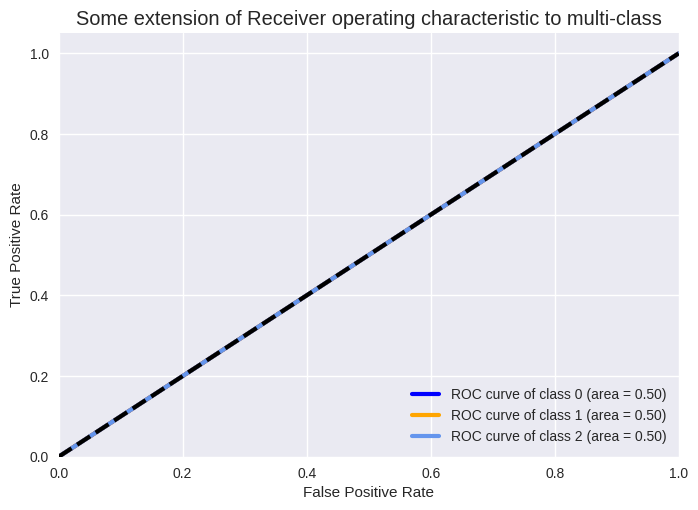

In [41]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Validation:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_new[:, i], Y_val_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_new.ravel(), Y_val_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Auc Curve on Test set:



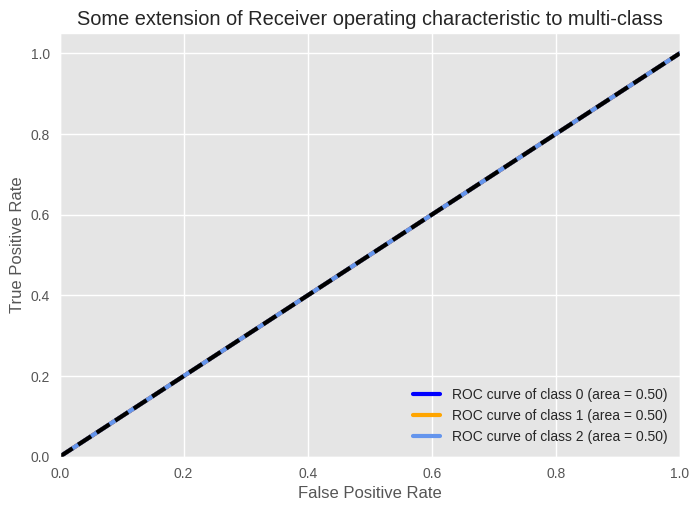

In [43]:

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

num_of_classes = y_train.shape[1]
print(f'Auc Curve on Test set:\n')


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_of_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_student[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred_student.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


lw = 3
# Plot all ROC curves

colors = cycle(['blue', 'orange', 'cornflowerblue'])
for i, color in zip(range(num_of_classes), colors):
    plt.plot(fpr[i],tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.style.use('ggplot')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()